<font size="4" id="prep"><b>Imports</b></font>

In [1]:
from __future__ import annotations

from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, ExponentialLR
import torch.backends.cudnn
import sys
import time
import torch
import random
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn import BCEWithLogitsLoss
from torch.nn.utils import clip_grad_norm_

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from typing import List, Iterable
from copy import deepcopy
from termcolor import colored

from PIL import Image
from tqdm.auto import tqdm

import torch.nn as nn
from torch.optim import AdamW
import segmentation_models_pytorch as smp

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2, gc
import os,warnings
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

<font size="4"><b>Config</b></font>

In [21]:
class CFG():
    """General configuration class for holding all project related details.
    """
    
    class DataPaths():
        """Contains details about paths in the dataset
        """
        base = "./kaggle/input/vesuvius-challenge-ink-detection"
        target = base + "/{dset}/{frag_id}/{filename}.png"
        x_ray = base + "/{dset}/{frag_id}/surface_volume/{{idx:>02}}.tif"
        models_dir = "./results/training"
    
    class DataLoad():
        """Contains details about the manner with which we load the data
        """
        # slices to load by index (out of 65)
        dlen = 6
        dstart = (65 - dlen) // 2
        dend = dstart + dlen
        
        # for chunks, in format (D, H, W)
        cdims = dlen, 224, 224
        cstride = dlen, 112, 112  # half
        
        # augmentations
        train_augs = [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.75),
                A.ShiftScaleRotate(p=0.75),
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.4),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
                A.Normalize(
                    mean= [0] * dlen,
                    std= [1] * dlen
                ),
                ToTensorV2(transpose_mask=True)
        ]

        valid_augs = [
            A.Normalize(
                mean= [0] * dlen,
                std= [1] * dlen
            ),
            ToTensorV2(transpose_mask=True),
        ]

        # for testing:
        test_cstride = dlen, 28, 28  # eighth
    
    class Train():
        device = "cuda:0" if torch.cuda.is_available() else "cpu"

        # loader
        train_batch_size = 16
        valid_batch_size = train_batch_size * 2
        num_workers = 0
        seed = 42

        # optimizer
        lr = 1e-4
        weight_decay = 1e-6

        # scheduler (ReduceLROnPlateau)
        patience = 5
        
        # mixed-precision and gradient clipping
        use_amp = True
        max_grad_norm = 1000
    
    class Test():
        use_TTA = True
        num_workers = 0
        batch_size = 16

<font size="6" id="1"><b>Introduction</b></font>

This notebook tackles the **Vesuvius Challenge** - We will attempt to train machine learning models to **detect ink** from 3d x-ray scans of broken fragemnts of papyri, which contains ink. Most of the work in this notebook will be based on [this notebook](https://www.kaggle.com/code/yoyobar/2-5d-segmentaion-model-with-rotate-tta/notebook#summary), which, as of writing this, holds the best attained public score.

<font size="5" id="1_1"><b>About the Task</b></font>

About 300 years ago, scrolls which once belonged to an ancient library in a Roman villa in Herculaneum were discovered and excavated. This villa was buried by the Vesuvius eruption nearly 2000 years ago, causing the scrolls to become carbonized, meaning that they cannot be opened without risking them being broken.

In order to see the ink inside the scrolls without opening them, 3d x-ray scans of some of the fragments of the scrolls were taken, and while those do not show the ink clearly, it was found that machine learning models can detect it, meaning that there is some data there.

Since the discovery, people have tried opening these scrolls, usually causing their destruction, but sometimes providing us with fragments with ink on them, which is especially visible under infra-red light. This provides us with some ground-truth data to train on.

( [Source - competition description](https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/overview) )

In terms of **computer vision**, this can be seen as a **segmentation task** - Given a set of categories which each pixel can belong to, we wish to assign one category to each pixel in a given image. In our case, the categories are [Ink, Not-Ink], and we wish to perform the assignment on pixels across the height and the width of a stack of images, representing the x-ray scan.

<font size="6" id="2"><b>Data Overview</b></font>

Before moving onto the task, we would like to **review the data** to get specific details about the samples we will be dealing with. Let's start with a review of the folders and files in the dataset.

In [3]:
for root, subdirs, files in os.walk(CFG.DataPaths.base):
    if len(files) > 0:
        print(root + ":")
        print(*sorted([f"{file}" for file in files]), sep="\t")
        print()

./kaggle/input/vesuvius-challenge-ink-detection:
sample_submission.csv

./kaggle/input/vesuvius-challenge-ink-detection\test\a:
mask.png

./kaggle/input/vesuvius-challenge-ink-detection\test\a\surface_volume:
00.tif	01.tif	02.tif	03.tif	04.tif	05.tif	06.tif	07.tif	08.tif	09.tif	10.tif	11.tif	12.tif	13.tif	14.tif	15.tif	16.tif	17.tif	18.tif	19.tif	20.tif	21.tif	22.tif	23.tif	24.tif	25.tif	26.tif	27.tif	28.tif	29.tif	30.tif	31.tif	32.tif	33.tif	34.tif	35.tif	36.tif	37.tif	38.tif	39.tif	40.tif	41.tif	42.tif	43.tif	44.tif	45.tif	46.tif	47.tif	48.tif	49.tif	50.tif	51.tif	52.tif	53.tif	54.tif	55.tif	56.tif	57.tif	58.tif	59.tif	60.tif	61.tif	62.tif	63.tif	64.tif

./kaggle/input/vesuvius-challenge-ink-detection\test\b:
mask.png

./kaggle/input/vesuvius-challenge-ink-detection\test\b\surface_volume:
00.tif	01.tif	02.tif	03.tif	04.tif	05.tif	06.tif	07.tif	08.tif	09.tif	10.tif	11.tif	12.tif	13.tif	14.tif	15.tif	16.tif	17.tif	18.tif	19.tif	20.tif	21.tif	22.tif	23.tif	24.tif	25.tif	26.tif	27.tif	28

It seems that each sample, train or test, gets its own folder. Each sample (Which represents a unique fragment) contains a set of **.tif images** representing the x-ray scan, a **mask.png image** representing where the fragment is in all other images.

Train samples also include a **inklables.png image**, a **inklabels_rle.csv** and an **ir.png image**, all representing the target.

Let's view the images for each sample.

<font size="5" id="2_1"><b>Train Images</b></font>

Let's review the mask and target of each sample in the training set.

c:\Users\rglki\anaconda3\envs\dlenv\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


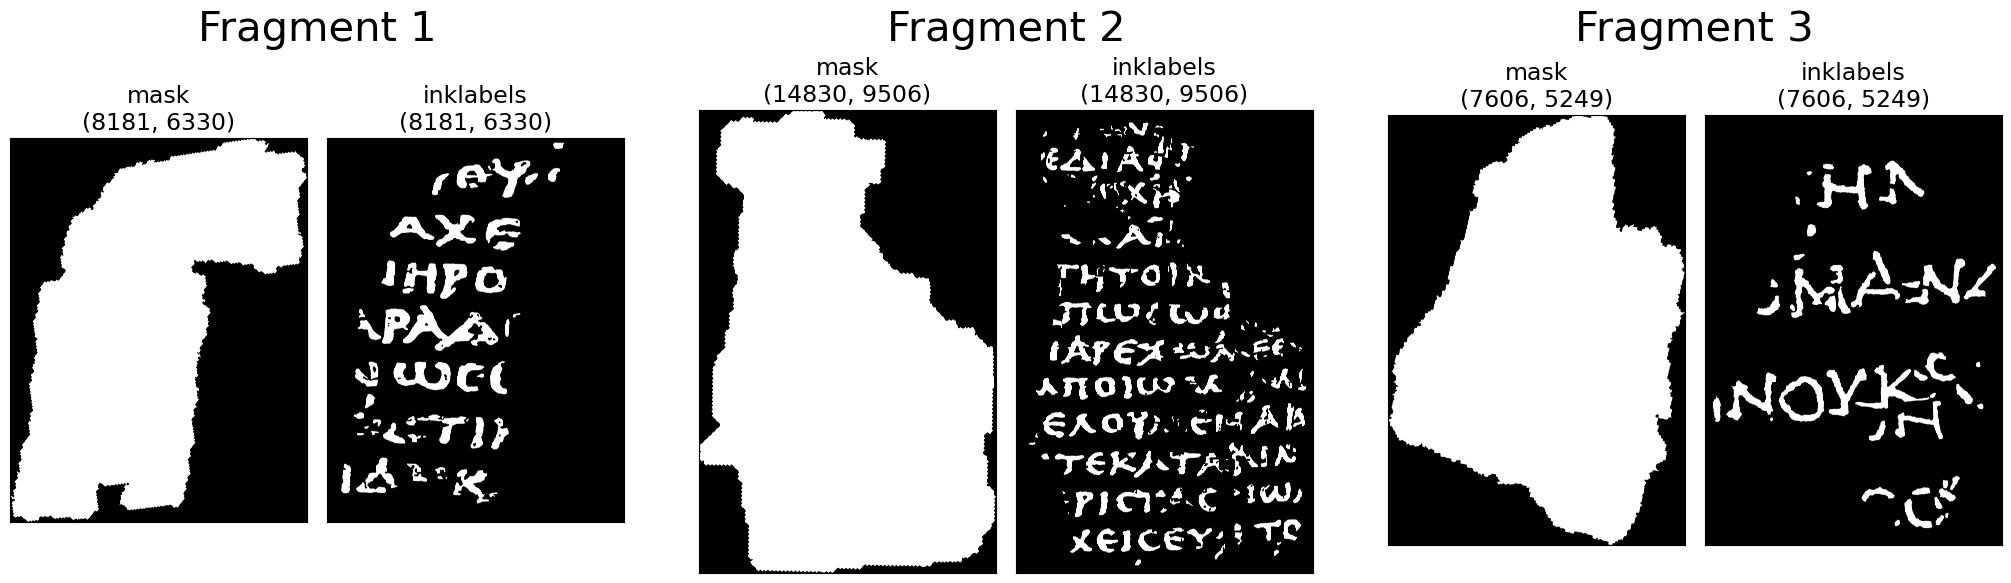

In [4]:
fig = plt.figure(figsize=(20, 6))
fig.set_layout_engine("constrained")
sfigures = fig.subfigures(nrows=1, ncols=3, wspace=0.1)

for frag_id, sfig in zip(range(1, 4), sfigures):
    axes = sfig.subplots(nrows=1, ncols=2)
    sfig.suptitle(f"Fragment {frag_id}", fontsize=30)
    
    for img_name, ax in zip(["mask", "inklabels"], axes):
        img_path = CFG.DataPaths.target.format(dset="train", frag_id=frag_id, filename=img_name)
        img = np.array(Image.open(img_path))
        ax.set_title(f"{img_name}\n{img.shape}", fontsize=17)
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])

Let's also review the some slices of the x-ray scans of each sample.

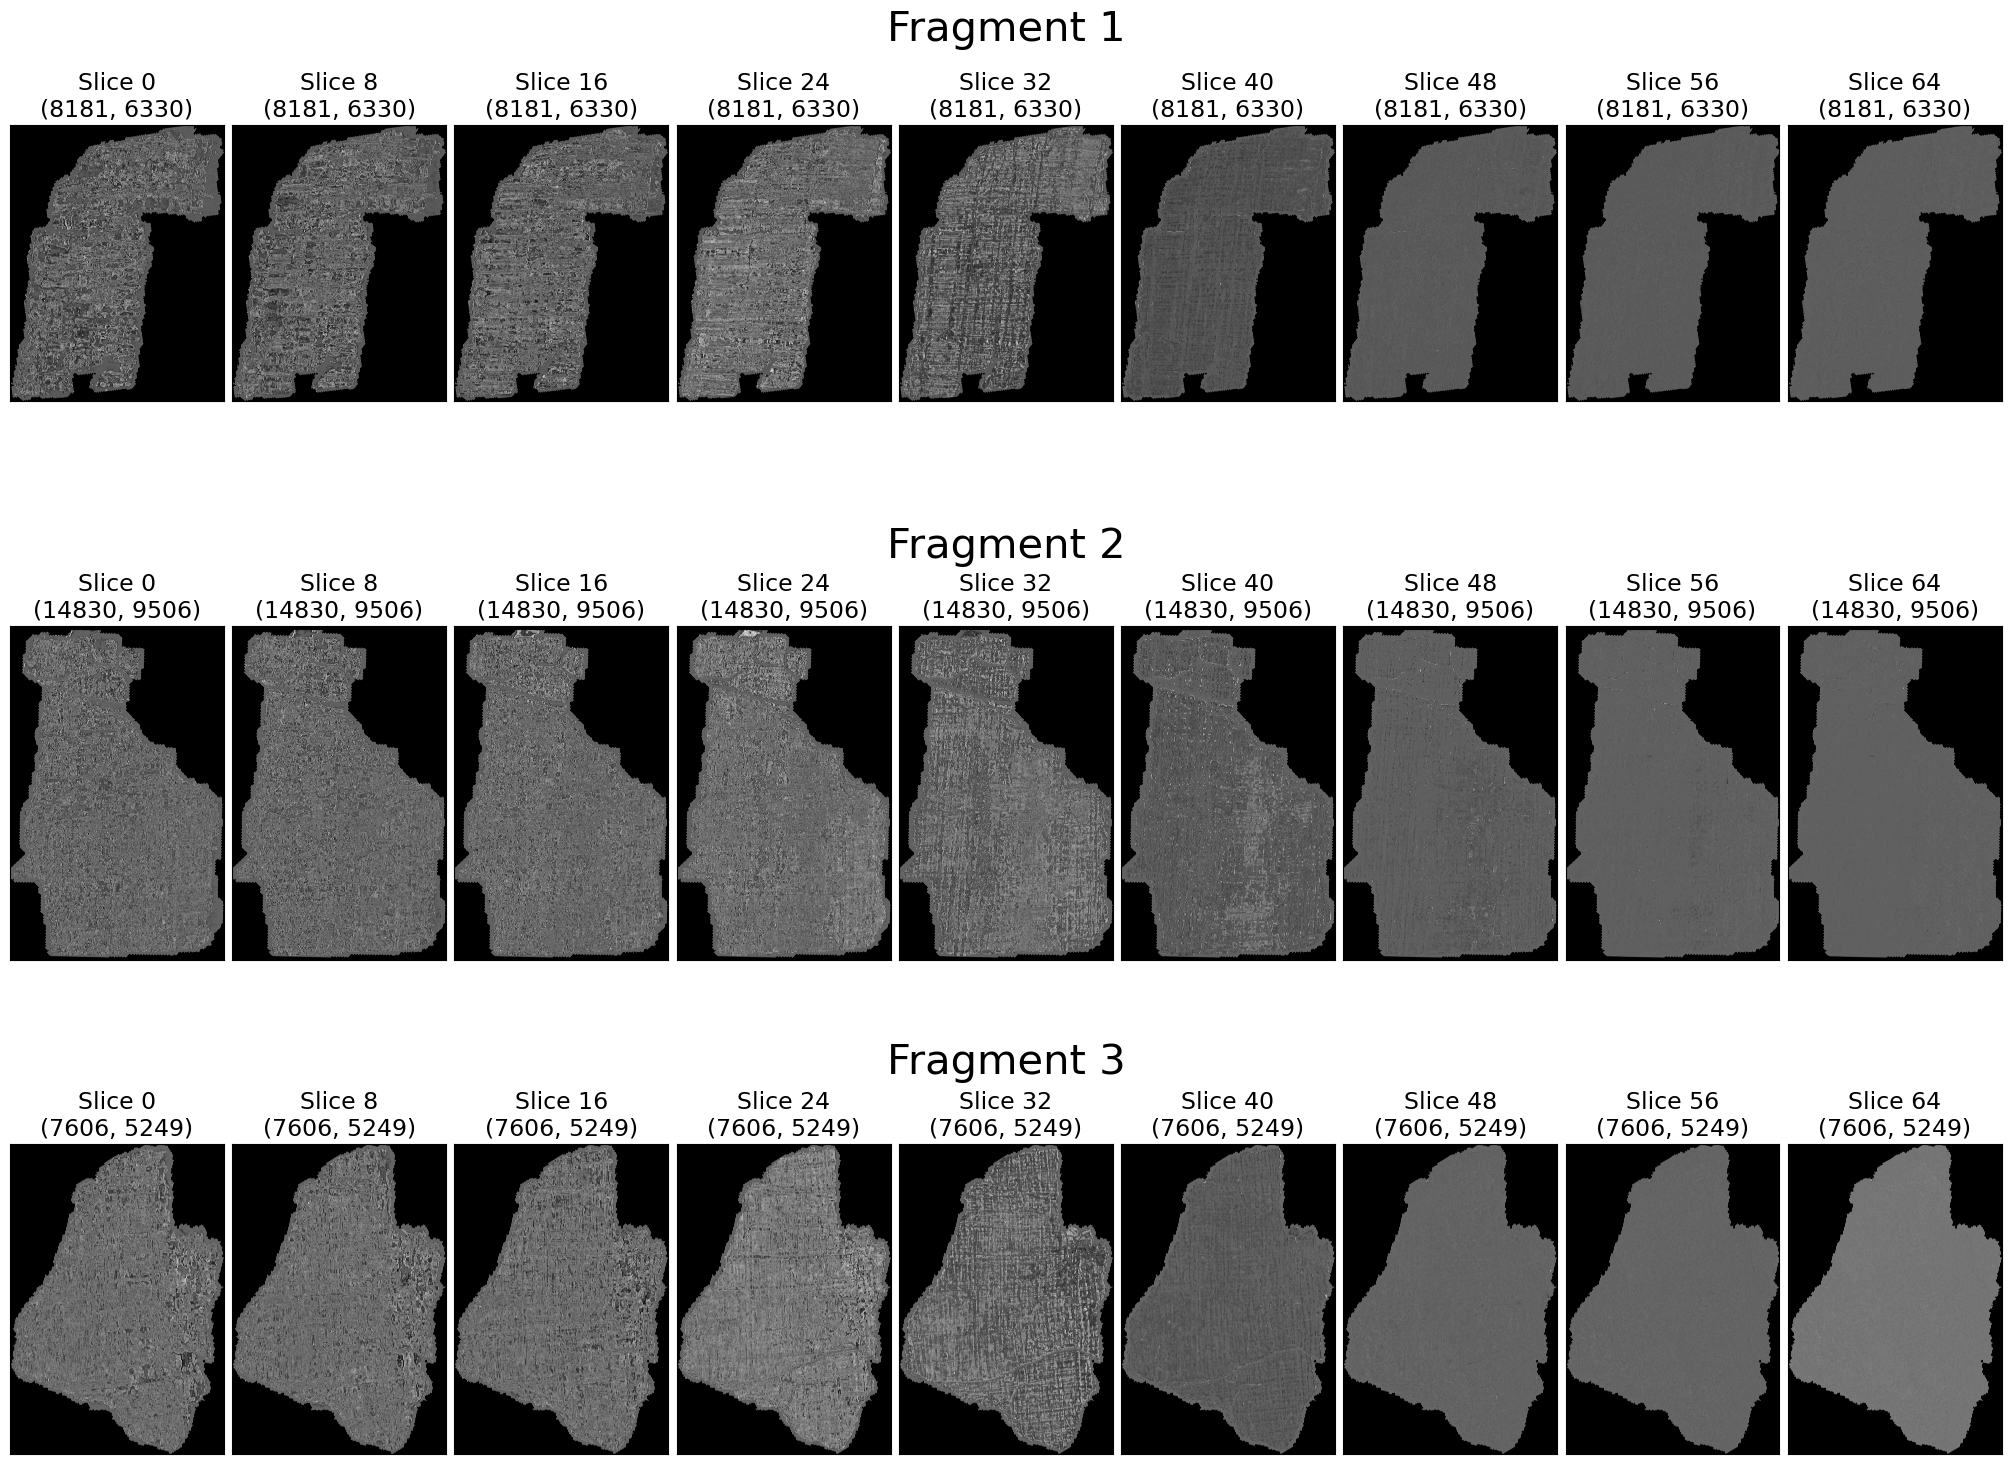

In [5]:
fig = plt.figure(figsize=(20, 15))
fig.set_layout_engine("constrained")
sfigures = fig.subfigures(nrows=3, ncols=1, hspace=0.1)

for frag_id, sfig in zip(range(1, 4), sfigures):
    axes = sfig.subplots(nrows=1, ncols=9)
    sfig.suptitle(f"Fragment {frag_id}", fontsize=30)
    
    for slice_ind, ax in zip(range(0, 65, 8), axes.flatten()):
        img_path = CFG.DataPaths.x_ray.format(dset="train", frag_id=frag_id).format(idx=slice_ind)
        img = np.array(Image.open(img_path))
        ax.set_title(f"Slice {slice_ind}\n{img.shape}", fontsize=17)
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])

<font size="5" id="2_2"><b>Test Images</b></font>

Let's review the mask of each sample in the test set aswell.

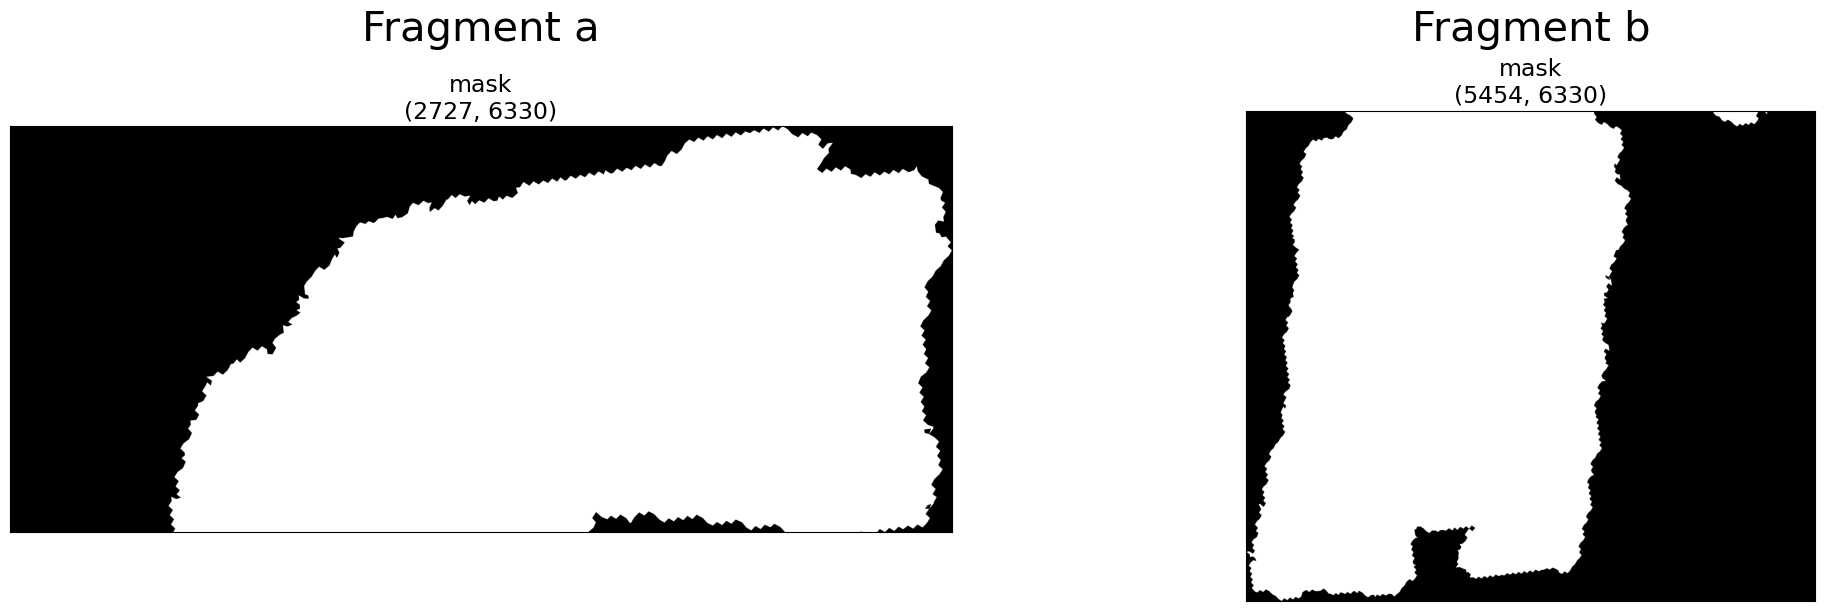

In [6]:
fig = plt.figure(figsize=(20, 6))
fig.set_layout_engine("constrained")
sfigures = fig.subfigures(nrows=1, ncols=2, wspace=0.1)

for frag_id, sfig in zip(["a", "b"], sfigures):
    ax = sfig.subplots(nrows=1, ncols=1)
    sfig.suptitle(f"Fragment {frag_id}", fontsize=30)
    
    img_path = CFG.DataPaths.target.format(dset="test", frag_id=frag_id, filename="mask")
    img = np.array(Image.open(img_path))
    ax.set_title(f"mask\n{img.shape}", fontsize=17)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

Let's also review the some slices of the x-ray scans of each sample.

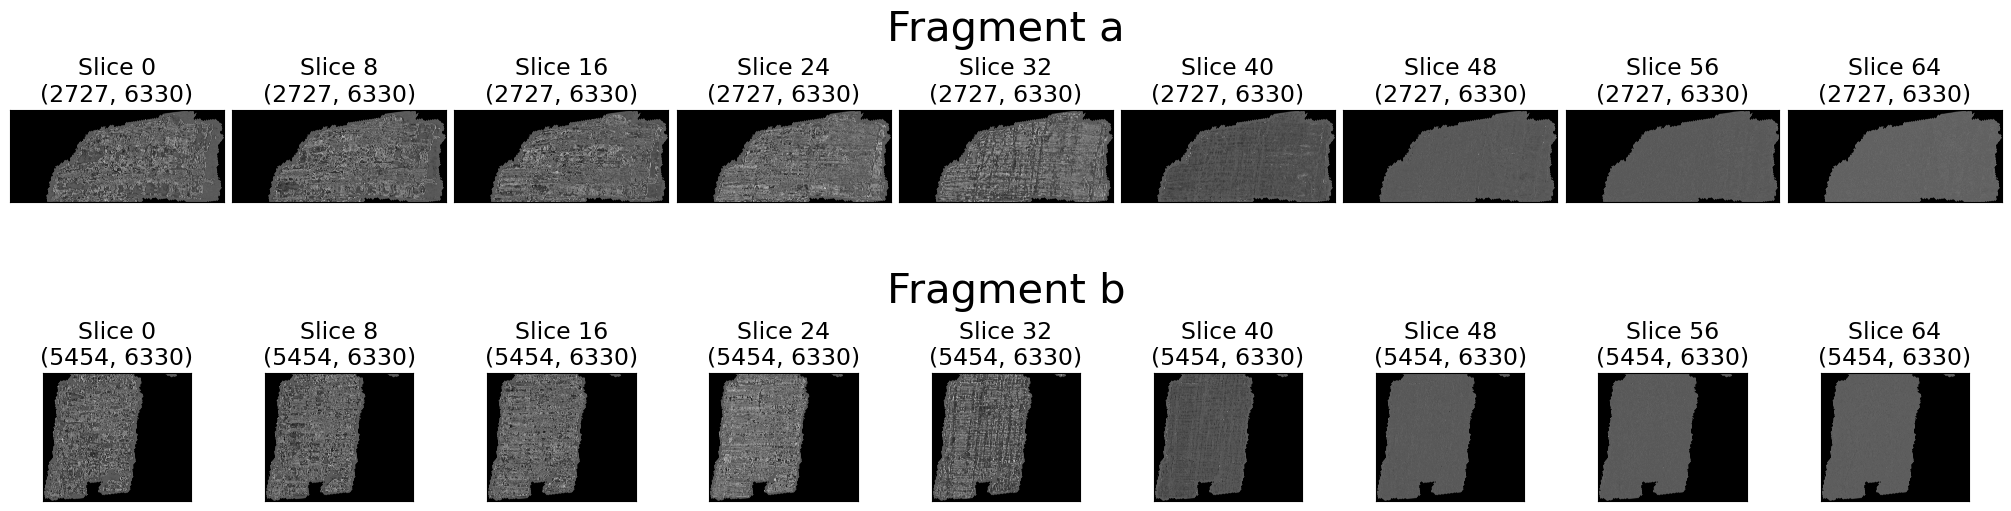

In [7]:
fig = plt.figure(figsize=(20, 5))
fig.set_layout_engine("constrained")
sfigures = fig.subfigures(nrows=2, ncols=1, hspace=0.1)

for frag_id, sfig in zip(["a", "b"], sfigures):
    axes = sfig.subplots(nrows=1, ncols=9)
    sfig.suptitle(f"Fragment {frag_id}", fontsize=30)
    
    for slice_ind, ax in zip(range(0, 65, 8), axes.flatten()):
        img_path = CFG.DataPaths.x_ray.format(dset="test", frag_id=frag_id).format(idx=slice_ind)
        img = np.array(Image.open(img_path))
        ax.set_title(f"Slice {slice_ind}\n{img.shape}", fontsize=17)
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])

<font size="5" id="2_3"><b>Observations</b></font>

Let's make a few observation which are relevant to how we will handle the task:
- There are **very few images** in this dataset - 3 for the training set, 2 for the test set.
    - This means we will lean towards **data augmentations** and **pretrained models**.
- The images in this dataset are **very large**, and of **irregular shape**.
    - This means we **cannot process an entire image with the neural networks we know** - There might be severe loss of data when attempting to resize these images. Instead, we can lean towards **disecting images and image stacks into tiles** - This may also help us with the small number of samples we have, and with generating **validation** for our models.
- There are **many slices** in each x-ray scan, and **earlier slices seem to be more homogenous than the latter slices**.
    - This means we may not want to process all slices - Maybe too many slices will confuse the models, and perhaps we would like to stick to earlier slices, as less variance can be indicative of less information (This is just a hypothesis as of now, we will try to test this later).

<font size="6" id="3"><b>Data Loading</b></font>

Now that we reviewed the available data, let's implement a way for **loading the data**. We will be using torch's **Dataset** class as a baseline, and implement a loader that is **flexible**. Let's go over some key-points for consideration here:
- Each sample contains a **3D image** as its features and **two 2D images** as its target. All of these have the same shape and one channel.
- Each sample has **irregular shape**. Therefore, we will create a dataset object that **handles single samples** (One object for each fragment).
- The samples are **way too large** - We would like to **pass parts of them to our models**.

Thus, we would like to create a **ChunksDataset class** - Given a fragment's id, we will return **chunks of the x-ray scan**, and their corresponding **mask and ink labels**.

<font size="5" id="3_1"><b>Chunks Dataset Class</b></font>

Because the chunks approach includes **much preprocessing**, to increase the class's flexibility on inheritance, we will use the **template design pattern** (In case we will like to change things in the future).

In [3]:
class ChunksDataset(Dataset):
    """Given a single 3d image with 2d mask and ink-labels, returns chunks from the image with the
    corresponding tiles from the mask and ink-labels.
    
    Uses the following process order:
        Pre-process the received parameters.
        Load the data (x-ray scan, mask, inklabels if exists).
        Process the loaded data.
        Generate index-list for loading.
    """
    
    def __init__(self, frag_id: str="1", dset: str="train", masked: bool=False,
                 cstride=CFG.DataLoad.cstride):
        super(ChunksDataset, self).__init__()

        assert dset in ["train", "test"]

        self.dset = dset
        self.frag_id = frag_id
        self.masked = masked
        self.cstride = np.array(list(cstride))

        if self.dset == "train":
            self.aug_mode = "train"
        
        self._preproc()
        self._load()
        self._proc_data()
        self._gen_idxs()
    
    def _preproc(self):
        pass
    
    def _load(self):
        img_path = CFG.DataPaths.x_ray.format(dset=self.dset, frag_id=self.frag_id)
        slices_idxs = range(CFG.DataLoad.dstart, CFG.DataLoad.dend)
        self.image_stack = np.stack([np.array(cv2.imread(img_path.format(idx=i), 0)) for i in slices_idxs])
        
        mask_path = CFG.DataPaths.target.format(
            dset=self.dset, frag_id=self.frag_id, filename="mask"
        )
        self.mask = np.array(cv2.imread(mask_path, 0)).astype("float32") / 255.0

        if self.dset == "train":
            ink_path = CFG.DataPaths.target.format(
                dset=self.dset, frag_id=self.frag_id, filename="inklabels"
            )
            self.ink = np.array(cv2.imread(ink_path, 0)).astype("float32") / 255.0
        
        self.og_shape = self.mask.shape
    
    def _proc_data(self):
        dims = np.array(CFG.DataLoad.cdims)
        
        pads = self.cstride - 1 - (self.image_stack.shape - dims - 1) % self.cstride
        pads = np.stack([np.zeros(pads.shape, dtype=int), pads], axis=1)
        
        self.image_stack = np.pad(self.image_stack, pads, constant_values=0)

        self.mask = np.pad(self.mask, pads[1:], constant_values=0)

        if self.dset == "train":
            self.ink = np.pad(self.ink, pads[1:], constant_values=0)
    
    def _gen_idxs(self):
        dims = np.array(CFG.DataLoad.cdims)
        
        idx_params = np.stack([
            np.zeros(dims.shape),
            self.image_stack.shape - dims + 1,
            self.cstride
        ]).astype(int).transpose()
        idx_ranges = [range(*tuple(p)) for p in idx_params]
        
        self.idxs = []
        for x in idx_ranges[0]:
            for y in idx_ranges[1]:
                for z in idx_ranges[2]:
                    if self.masked:
                        if not np.sum(self.mask[y : y+dims[1], z : z+dims[2]]) == 0:
                            self.idxs.append([x, y, z])
                    else:
                        self.idxs.append([x, y, z])
        
        self.idxs = np.array(self.idxs)
    
    def get_og_shape(self):
        return self.og_shape

    def set_aug_mode(self, mode):
        assert self.dset == "train"
        assert mode in ["train", "valid"]

        self.aug_mode = mode

    def get_aug_mode(self):
        return self.aug_mode
    
    def _get_chunk(self, idx: int):
        start_idxs = self.idxs[idx]
        dims = np.array(CFG.DataLoad.cdims)
        end_idxs = start_idxs + dims
        
        chunk = self.image_stack[
            start_idxs[0]:end_idxs[0],
            start_idxs[1]:end_idxs[1],
            start_idxs[2]:end_idxs[2]
        ]
        chunk = chunk.transpose(1, 2, 0)

        mask = self.mask[start_idxs[1]:end_idxs[1], start_idxs[2]:end_idxs[2]]

        if self.dset == "train":
            ink = self.ink[start_idxs[1]:end_idxs[1], start_idxs[2]:end_idxs[2]]
            
            if self.aug_mode == "train":
                transforms = A.Compose(CFG.DataLoad.train_augs, additional_targets={"ink": "mask"})
            else:
                transforms = A.Compose(CFG.DataLoad.valid_augs, additional_targets={"ink": "mask"})
            augmented = transforms(image=chunk, mask=mask, ink=ink)
            
            chunk = augmented["image"]
            mask = augmented["mask"]
            ink = augmented["ink"]
            
        else:
            transforms = A.Compose(CFG.DataLoad.valid_augs)
            augmented = transforms(image=chunk, mask=mask)
            
            chunk = augmented["image"]
            mask = augmented["mask"]
        
        if self.dset == "train":
            return chunk, mask, ink, start_idxs
        else:
            return chunk, mask, start_idxs

    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self._get_chunk(i) for i in range(len(self))[idx]]
        return self._get_chunk(idx)

<font size="5" id="3_2"><b>Helper Classes</b></font>

Let's also implement some helpful classes for training later.

In [4]:
class PartialDataset(Dataset):
    """Given an existing chunks dataset, simulates a new dataset which contains items from the
    original dataset in certain indexes.

    Also sets the mode of the original dataset when returning items
    """
    def __init__(self, original: ChunksDataset, idxs: List[int], mode: str="train"):
        assert original.dset == "train"
        assert mode in ["train", "valid"]

        self.original = original
        self.mode = mode
        self.idxs = idxs
    
    def __len__(self):
        return len(self.idxs)
    
    def get_chunk(self, idx):
        original_mode = self.original.get_aug_mode()
        self.original.set_aug_mode(self.mode)

        back = self.original[self.idxs[idx]]
        
        self.original.set_aug_mode(original_mode)

        return back
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            back = []
            for i in range(len(self))[idx]:
                back.append(self.get_chunk(i))
            
            return back
        
        return self.get_chunk(idx)

In [5]:
class ConcatDataset(Dataset):
    """Dataset simulating a concatenation of multiple datasets.
    """

    def __init__(self, datasets: Iterable[ChunksDataset]):
        super().__init__()
        self.datasets = list(datasets)

    def __len__(self):
        return sum([len(ds) for ds in self.datasets])

    def get_chunk(self, idx: int):
        ds_idx = 0
        while idx >= len(self.datasets[ds_idx]):
            idx -= len(self.datasets[ds_idx])
            ds_idx += 1
        
        return self.datasets[ds_idx][idx]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            back = []
            for i in range(len(self))[idx]:
                back.append(self.get_chunk(i))
            
            return back
        
        return self.get_chunk(idx)

In [7]:
class BasicDatasetsManager():
    """For managing loading all datasets and shuffling train-validation splits.

    Loads all datasets for either train or test, and on requests - randomly splits (if train),
    concatenates and returns the prepared datasets.
    """
    def __init__(self, dset="train", masked=False):
        assert dset in ["train", "test"]

        self.dset = dset
        
        if dset == "train":
            fragments = ["1", "2", "3"]
        else:  # test
            fragments = ["a", "b"]
            
        self.datasets = [ChunksDataset(fid, dset, masked) for fid in fragments]
    
    def get_datasets(self, split_ratio=0.8):
        if self.dset == "train":
            train_sets = []
            valid_sets = []
            
            for ds in self.datasets:
                train_size = int(len(ds) * split_ratio)
                perm = np.random.permutation(len(ds))
            
                train_set = PartialDataset(ds, perm[:train_size], mode="train")
                valid_set = PartialDataset(ds, perm[train_size:], mode="valid")

                train_sets.append(train_set)
                valid_sets.append(valid_set)
        
            train_set = ConcatDataset(train_sets)
            valid_set = ConcatDataset(valid_sets)

            return train_set, valid_set
        else:
            return self.datasets

In [8]:
class FoldedDatasetsManager():
    """Another manager created for folding the datasets when training.

    Receives names of the fragments which belong to the training set, and names
    of the fragments which belong to the validation set.
    """
    def __init__(self, train_frags: List[str], valid_frags: List[str], masked=False):
        assert set(train_frags + valid_frags).issubset({"1", "2", "3"})

        train_datasets = [ChunksDataset(fid, "train", masked) for fid in train_frags]
        for tds in train_datasets:
            tds.set_aug_mode("train")

        valid_datasets = [ChunksDataset(fid, "train", masked) for fid in valid_frags]
        for vds in valid_datasets:
            vds.set_aug_mode("valid")
        
        self.train_set = ConcatDataset(train_datasets)
        self.valid_set = ConcatDataset(valid_datasets)
        
    
    def get_datasets(self):
       return self.train_set, self.valid_set

In [9]:
class DatasetsManagerDebug():
    """For debugging purposes - load only first fragment.
    """
    def __init__(self, masked=False):
        self.dataset = ChunksDataset("1", "train", masked)
    
    def get_datasets(self, split_ratio=0.8):
        train_size = int(len(self.dataset) * split_ratio)
        perm = np.random.permutation(len(self.dataset))

        train_set = PartialDataset(self.dataset, perm[:train_size], mode="train")
        valid_set = PartialDataset(self.dataset, perm[train_size:], mode="valid")

        return train_set, valid_set

<font size="6" id="4"><b>Models</b></font>

Now that we have a way of loading the data, let's implement various models we will be training.

- Initially, we will be training **basic segmentation models** from the *Segmentation-Models-Pytorch* library.
- We will also be **folding the data** - Setting one fragment as validation and training one model per fold. Eventually, the three models we train will be combined to create a **Bagging Ensemble**.

Let's go ahead and implement all of those.

<font size="5" id="4_1"><b>Basic Segmentation Models</b></font>

We will first be making use of the *Segmentaion-Models-Pytorch* library and its models as a **baseline** for more advanced models.

In [4]:
def get_basic_model(components, model_data=None):
    """Helper method for building and loading models.
    """
    model = smp.create_model(*components, in_channels=CFG.DataLoad.dlen, classes=1) 

    if model_data is not None:
        model.load_state_dict(model_data)
        
    return model

<font size="5" id="4_2"><b>Basic Ensembles</b></font>

We will also be making use of **bagging ensemble models**.

In [5]:
class BaggingEnsembleModel(nn.Module):
    def __init__(self, models: List[nn.Module]):
        super().__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x: torch.tensor):
        preds = torch.stack([m(x) for m in self.models]).float()
        out = preds.mean(dim=0)

        return out

In [6]:
def get_ensemble(comp_list, model_paths=None):
    if isinstance(comp_list, tuple):
        if model_paths is None:
            comp_list = [comp_list]
        else:
            comp_list = [comp_list] * len(model_paths)

    models = [smp.create_model(*c, in_channels=CFG.DataLoad.dlen, classes=1) for c in comp_list]

    if model_paths is not None:
        for i, mp in enumerate(model_paths):
            if mp is not None:
                state_dict = torch.load(f"{CFG.DataPaths.models_dir}/{mp}")["best"]["model"]
                models[i].load_state_dict(state_dict)
    
    return BaggingEnsembleModel(models)

<font size="5" id="4_3"><b>Meta Models</b></font>

We would also like to take our already trained models and combine them into a more complicated ensemble - A **stacking ensemble** which will make use of some **meta-model**.

In [13]:
class MetaModel(nn.Module):
    def __init__(self, base_models: List[nn.Module], meta_model: nn.Module):
        super().__init__()

        self.base_models = nn.ModuleList(base_models)
        self.meta_model = meta_model

        for model in self.base_models:
            for param in model.parameters():
                param.requires_grad = False
    
    def forward(self, x: torch.tensor):
        base_preds = torch.cat([m(x) for m in self.base_models], dim=1).float()
        out = self.meta_model(base_preds)

        return out

In [14]:
def get_metamodel(base_comp_list, base_model_paths, meta_comps):
    if isinstance(base_comp_list, tuple):
        base_comp_list = [base_comp_list] * len(base_model_paths)

    base_models = [smp.create_model(*c, in_channels=CFG.DataLoad.dlen, classes=1) for c in base_comp_list]
    
    for i, mp in enumerate(base_model_paths):
        state_dict = torch.load(f"{CFG.DataPaths.models_dir}/{mp}")["best"]["model"]
        base_models[i].load_state_dict(state_dict)
    
    meta_model = smp.create_model(*meta_comps, in_channels=len(base_models), classes=1)

    return MetaModel(base_models, meta_model)

<font size="5" id="4_4"><b>Stacked Multi-Models</b></font>

Finally, we would like to try and **stack segmentation models** - We will train an architectures that is composed of a few models in its first level, with some number of classes, and then pass their predictions (Concatenated) to a second-level model.

In [15]:
class StackedMultiModel(nn.Module):
    def __init__(self, lvl1_models: List[nn.Module], lvl2_model: nn.Module):
        super().__init__()

        self.lvl1_models = nn.ModuleList(lvl1_models)
        self.lvl2_model = lvl2_model
    
    def forward(self, x: torch.tensor):
        base_preds = torch.cat([m(x) for m in self.lvl1_models], dim=1).float()
        out = self.lvl2_model(base_preds)

        return out

In [16]:
def get_stacked_multimodel(lvl1_comp_list, lvl1_output_channels, lvl2_comps):
    lvl1_models = [smp.create_model(*c, in_channels=CFG.DataLoad.dlen, classes=lvl1_output_channels) for c in lvl1_comp_list]
    lvl2_model = smp.create_model(*lvl2_comps, in_channels=len(lvl1_comp_list) * lvl1_output_channels, classes=1)

    return MetaModel(lvl1_models, lvl2_model)

<font size="6" id="5"><b>Metrics and Losses</b></font>

Now that we have data and we have models, let's go ahead and define the **metrics** and **losses** for the training process:

- For **metrics**, we will simply use the contest's defined metric - **F-Beta Score**. This metric is similar to the F1 Score, except that it **weighs percision differently from recall**. In our case, beta is 0.5, meaning that percision should be prioritized over recall.

- For **losses**, we will be using:
    - **Weighted Binary Cross Entropy (With Logits)** - We will make it so the **penalty of false-positives is greater than the penalty of false-negaatives**, to prioritize percision over recall. The weighted formula looks like so:
    $$L(x, y) = \frac {1} {n} \sum_{i=1}^n {l(x_i, y_i)}, \qquad l(x, y) = -\alpha \cdot y \log {\sigma (x)} -(1-y) \log {\sigma (1-x)}$$
    - **Masked Losses** - We will be implementing variants of existing losses by using the sample's mask - Since we know where the fragment is in the imaging, we can **set predictions outside of the mask to 0**. This will effectively let the model ignore areas outside of the masks. When we do this, we will be sure to avoid loading chunks which are completely outside of the masks.

<font size="5" id="5_1"><b>Metrics</b></font>

Let's implement the **F-Beta Score**. We will make sure to do so in such a way that accurately represents existing implementations from kaggle, while being **memory efficient**, since we would like their calculation process to be done by GPU. We will be **summing true-positives, false-positives and false-negatives across batches for each threshold in $[0.01, ..., 1]$**. Do note that this (And existing) implementations **do not account for overlap of chunks**, therefore the scoring may be somewhat off (As prediction involves averaging on overlap).

In [7]:
def metrics_by_thresh(targets, raw_preds):
    back = torch.tensor([])
    targets = targets.flatten()
    raw_preds = raw_preds.flatten()
    
    for th in range(0, 101):
        th *= 0.01
        preds = (raw_preds >= th).int()

        tp = preds[targets==1].sum()
        fp = preds[targets==0].sum()
        fn = (1 - preds)[targets==1].sum()
        
        to_cat = torch.tensor([[tp, fp, fn]]).transpose(1, 0)
        back = torch.cat([back, to_cat], dim=1)

    return back

In [8]:
def best_fbeta_thresh(metrics, beta=0.5, smooth=1e-7):
    tp, fp, fn = tuple(metrics)
    p = tp / (tp + fp + smooth)
    r = tp / (tp + fn + smooth)

    beta_2 = beta * beta
    fbeta = (1 + beta_2) * p * r / (beta_2 * p + r + smooth)

    best_ind = torch.argmax(fbeta).item()
    best_th = best_ind * 0.01
    best_fbeta = fbeta[best_ind]

    return best_fbeta, best_th

<font size="5" id="5_2"><b>Losses</b></font>

Let's go ahead and implement the losses we mentioned before. Do note that the weighting in **BCE** is already implemented in pytorch, therefore we can avoid implemening it ourselves.

In [9]:
class MaskedLoss(nn.Module):
    """Masks an existing implementation of a loss.
    """
    def __init__(self, loss: nn.Module):
        super().__init__()
        self.loss = loss

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        new_y_pred = torch.mul(y_pred, mask)
        new_y_true = torch.mul(y_true, mask)
        return self.loss(new_y_pred, new_y_true)

<font size="6" id="6"><b>Defining the Training Process</b></font>

We are finally ready to define tools - classes and methods - to aid us when training.

<font size="5" id="6_1"><b>Helper Classes and Methods</b></font>

In [10]:
def gpu_mem():
    """Returns memory allocated to gpu, for debugging purposes.
    """
    return torch.cuda.memory_allocated()

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def set_seed(seed=None, cudnn_deterministic=True):
    """Sets the seed for training.
    """
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

<font size="5" id="6_2"><b>Defining an Epoch</b></font>

For oranization sake, we would like to separate the functionality of **training and validation** from the implementation of the training loop. For each of those processes (In the context of a single epoch), we would like to either train/validate, while keeping track of loss and optimal threshold and score combinations, for each batch (For display) and overall (For some evaluation later).

For training, we will also be making use of pytorch's **mixed percision implementations** and **gradient clipping**.

In [13]:
def train_fn(epoch, train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.Train.use_amp)
    losses = AverageMeter()
    sum_metrics = torch.zeros((3, 101))

    with tqdm(enumerate(train_loader), total=len(train_loader), colour="#7695c4") as iterator:
        iterator.set_description(f"Epoch {epoch:<2}")
        for _, (chunks, masks, inks, _) in iterator:
            chunks = chunks.to(device).float()
            masks = masks.to(device).float()
            inks = inks.to(device).float()
            batch_size = inks.size(0)

            with autocast(CFG.Train.use_amp):
                y_preds = model(chunks).squeeze()
                # loss = criterion(y_preds, inks, masks)
                loss = criterion(y_preds, inks)

            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()

            clip_grad_norm_(model.parameters(), CFG.Train.max_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            with torch.no_grad():
                y_preds = torch.sigmoid(y_preds)
                metrics = metrics_by_thresh(inks, y_preds)
                fbeta, thresh = best_fbeta_thresh(metrics)
                sum_metrics += metrics

            iterator.set_postfix_str(f"{'':<5}{'TRAINING':<12}{':':<5} loss={loss:.3e} | score={fbeta:.3e} | threshold={thresh} | "\
                                     +f"lr={optimizer.param_groups[0]['lr']:.3e}")

    with torch.no_grad():
        fbeta, best_thresh = best_fbeta_thresh(sum_metrics)

    return losses.avg, fbeta, best_thresh

In [30]:
def valid_fn(epoch, valid_loader, model, criterion, device):
    model.eval()

    losses = AverageMeter()
    sum_metrics = torch.zeros((3, 101))
    
    with torch.no_grad():
        with tqdm(enumerate(valid_loader), total=len(valid_loader), colour="#faa95c") as iterator:
            iterator.set_description(f"Epoch {epoch:<2}")
            for _, (chunks, masks, inks, _) in iterator:
                chunks = chunks.to(device).float()
                masks = masks.to(device).float()
                inks = inks.to(device).float()
                batch_size = inks.size(0)

                y_preds = model(chunks).squeeze()
                # loss = criterion(y_preds, inks, masks)
                loss = criterion(y_preds, inks)
                losses.update(loss.item(), batch_size)

                y_preds = torch.sigmoid(y_preds)
                metrics = metrics_by_thresh(inks, y_preds)
                fbeta, thresh = best_fbeta_thresh(metrics)
                sum_metrics += metrics

                iterator.set_postfix_str(f"{'':<5}{'VALIDATION':<12}{':':<5} loss={loss:.3e} | score={fbeta:.3e} | threshold={thresh}")
            
        fbeta, best_thresh = best_fbeta_thresh(sum_metrics)
    
    return losses.avg, fbeta, best_thresh

<font size="5" id="6_3"><b>Training Process</b></font>

Now we are ready to combine all of the above to implement a training process. We will make it so that this training process can train fresh and already trained models by saving states and loading them.

In [15]:
def train_model(data_manager, model: nn.Module, model_name: str="no-name",
                fresh: bool=True, num_epochs: int=15):
    # setup
    print(f"Device: {CFG.Train.device}")
    start_time = time.time()

    if fresh:
        to_write = {"epochs": {}}
        best_score = 0
        prev_time = 0
    else:
        to_write = torch.load(f"{CFG.DataPaths.models_dir}/{model_name}.pth")

        best_epoch = to_write["best"]["epoch"]
        best_score = to_write["epochs"][best_epoch]["valid_score"]
        
        prev_time = to_write["end"]["time"]
        model.load_state_dict(deepcopy(to_write["end"]["model"]))

    model.to(CFG.Train.device)
    last_epoch = len(to_write["epochs"])
    optimizer = AdamW(model.parameters(), lr=CFG.Train.lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=5)

    if not fresh:
        optimizer.load_state_dict(to_write["end"]["optimizer"])
        scheduler.load_state_dict(to_write["end"]["scheduler"])

    criterion = BCEWithLogitsLoss(pos_weight=torch.tensor(0.25))
    # criterion = MaskedLoss(BCEWithLogitsLoss(pos_weight=torch.tensor(0.25)))
    

    # train (with save-states)
    for epoch in range(num_epochs):
        # start_gpu = gpu_mem()
        epoch += last_epoch + 1

        train_set, valid_set = data_manager.get_datasets()
        train_loader = DataLoader(train_set, CFG.Train.train_batch_size, shuffle=True,
                                  num_workers=CFG.Train.num_workers)
        valid_loader = DataLoader(valid_set, CFG.Train.valid_batch_size, shuffle=False,
                                  num_workers=CFG.Train.num_workers)

        train_loss, train_fbeta, train_thresh = train_fn(epoch, train_loader, model, criterion, optimizer, CFG.Train.device)
        val_loss, valid_fbeta, valid_thresh = valid_fn(epoch, valid_loader, model, criterion, CFG.Train.device)

        params = {'train_thresh': train_thresh, 'valid_thresh': valid_thresh, 'train_score': train_fbeta,
                  'valid_score': valid_fbeta, 'train_loss': train_loss, 'valid_loss': val_loss,
                  'lr': scheduler.optimizer.param_groups[0]['lr']}

        to_write["epochs"][epoch] = deepcopy(params)

        if valid_fbeta > best_score:
            best_score = valid_fbeta
            
            to_save = {"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                       "scheduler": scheduler.state_dict(), "epoch": epoch}
            
            torch.save(to_save, f"{CFG.DataPaths.models_dir}/[TEMP]{model_name}.pth")
        
        scheduler.step()

        # clean-up
        torch.cuda.empty_cache()
        gc.collect()
        # print(start_gpu, gpu_mem() - start_gpu)
        
    # save
    end_time = time.time() - start_time
    
    to_write["best"] = torch.load(f"{CFG.DataPaths.models_dir}/[TEMP]{model_name}.pth")
    to_write["end"] = {"model": model.cpu().state_dict(), "optimizer": optimizer.state_dict(),
                       "scheduler": scheduler.state_dict(), "time": prev_time + end_time}
    
    torch.save(to_write, f"{CFG.DataPaths.models_dir}/{model_name}.pth")

    print(f"Time took for this training session: {end_time}")

<font size="6" id="7"><b>Training Models</b></font>

The following is an example of a code snippet used to train the a model in this project.

In [26]:
torch.cuda.empty_cache()
gc.collect()

data_mgr = BasicDatasetsManager()
model = get_stacked_multimodel(
    [("unet", "se_resnext50_32x4d"), ("unet", "efficientnet-b2")],
    3,
    ("unet", "se_resnext50_32x4d"))
train_model(data_mgr, model, f"Stacked_Unet_MultiModel_v1", True, 10)

time.sleep(600)

data_mgr = BasicDatasetsManager()
model = get_stacked_multimodel(
    [("unet", "se_resnext50_32x4d"), ("unet", "efficientnet-b2")],
    3,
    ("unet", "se_resnext50_32x4d"))
train_model(data_mgr, model, f"Stacked_Unet_MultiModel_v1", False, 10)

time.sleep(600)

data_mgr = BasicDatasetsManager()
model = get_stacked_multimodel(
    [("unet", "se_resnext50_32x4d"), ("unet", "efficientnet-b2")],
    3,
    ("unet", "se_resnext50_32x4d"))
train_model(data_mgr, model, f"Stacked_Unet_MultiModel_v1", False, 10)

del data_mgr

Device: cuda:0


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Time took for this training session: 4238.253273010254
Device: cuda:0


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Time took for this training session: 4207.472859859467
Device: cuda:0


  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/913 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Time took for this training session: 4210.303658723831


<font size="6" id="8"><b>Results</b></font>

To summarize, let's go over some of the better results of our models.

- We will plot loss and score graphs.
- We will also plot to show ink which was detected on the training examples.

<font size="5" id="8_1"><b>Helper Methods</b></font>

In [16]:
def TTA(x:torch.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    if CFG.Test.use_TTA:
        shape=x.shape
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=torch.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=torch.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x

<font size="5" id="8_1"><b>Generating Results</b></font>

In [17]:
def plot_graphs(epochs_data: dict, model_name: str):
    t_losses = [epochs_data[i]["train_loss"] for i in range(1, len(epochs_data) + 1)]
    v_losses = [epochs_data[i]["valid_loss"] for i in range(1, len(epochs_data) + 1)]
    t_scores = [epochs_data[i]["train_score"] for i in range(1, len(epochs_data) + 1)]
    v_scores = [epochs_data[i]["valid_score"] for i in range(1, len(epochs_data) + 1)]
    lrs      = [epochs_data[i]["lr"] for i in range(1, len(epochs_data) + 1)]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), layout="constrained")
    fig.suptitle(f"Graphs for {model_name}", fontsize=30, weight="bold")

    axes[0].plot(t_losses, "#7695c4", label="train")
    axes[0].plot(v_losses, "#faa95c", label="valid")
    axes[0].set_ylim(0, 0.2)
    axes[0].legend(labels=["train", "valid"])
    axes[0].set_title("Loss by epoch", fontsize=15)

    axes[1].plot(t_scores, "#7695c4", label="train")
    axes[1].plot(v_scores, "#faa95c", label="valid")
    axes[1].set_ylim(0, 1)
    axes[1].legend(labels=["train", "valid"])
    axes[1].set_title("Score by epoch", fontsize=15)

    axes[2].plot(lrs, "#3df500")
    axes[2].set_title("Learning Rate by Epoch", fontsize=15)

    plt.show()

In [18]:
def show_predictions(model: nn.Module, model_name: str, frag_id: str="1"):
    model = model.cuda()

    dataset = ChunksDataset(frag_id, "train", cstride=CFG.DataLoad.test_cstride)
    data_loader = DataLoader(dataset, batch_size=CFG.Test.batch_size,  shuffle=False,
                                num_workers=CFG.Test.num_workers, pin_memory=True,
                                drop_last=False)
    
    raw_pred = torch.zeros(dataset.mask.shape).cuda()
    mask_count = torch.zeros(raw_pred.shape).cuda()
    
    for step, (chunks, _, _, idxs) in tqdm(enumerate(data_loader), total=len(data_loader)):
        chunks = chunks.cuda()
        
        with torch.no_grad():
            y_preds = TTA(chunks, model)

        # reassemble mask:
        for pred, idx in zip(y_preds, idxs):
            y1, x1 = idx[1], idx[2]
            y2, x2 = y1 + pred.shape[0], x1 + pred.shape[1]
            
            raw_pred[y1:y2, x1:x2] += pred
            mask_count[y1:y2, x1:x2] += torch.ones(pred.shape).cuda()
    
    # fix overlapping predictions:
    raw_pred /= mask_count

    fbeta, thresh = best_fbeta_thresh(metrics_by_thresh(
        torch.tensor(dataset.ink), raw_pred
    ))
    
    true_pred = raw_pred * torch.tensor(dataset.mask).cuda()
    true_pred = (true_pred >= thresh).int()
    
    og_shape = dataset.get_og_shape()
    raw_pred = raw_pred[:og_shape[0], :og_shape[1]]
    true_pred = true_pred[:og_shape[0], :og_shape[1]].cpu()
    og_ink = torch.tensor(dataset.ink[:og_shape[0], :og_shape[1]])
    
    plt.imshow(torch.stack([true_pred, torch.zeros(true_pred.shape), og_ink], axis=2))
    plt.suptitle(f"{model_name}\nscore={fbeta.item():.3f}, {thresh=}", fontsize=15)
    del data_loader
    
    torch.cuda.empty_cache()
    gc.collect()

    plt.show()

In [19]:
def generate_results(model: nn.Module, model_name: str):
    loaded = torch.load(f"{CFG.DataPaths.models_dir}/{model_name}.pth")

    plot_graphs(loaded["epochs"], model_name)
    model.load_state_dict(loaded["best"]["model"])

    show_predictions(model, model_name)

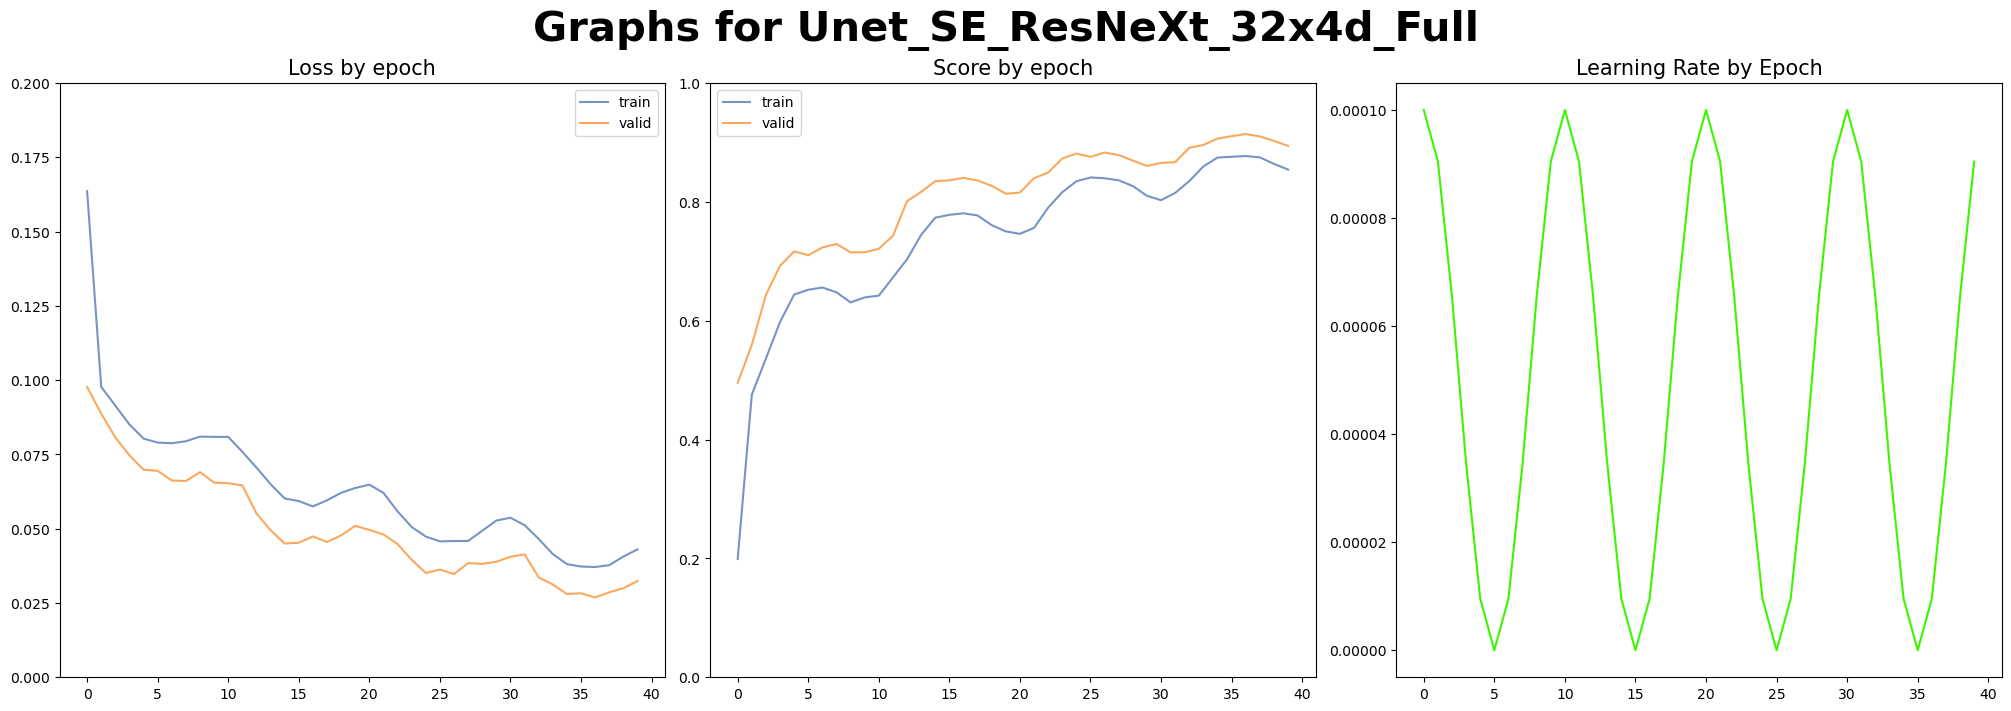

  0%|          | 0/3933 [00:00<?, ?it/s]

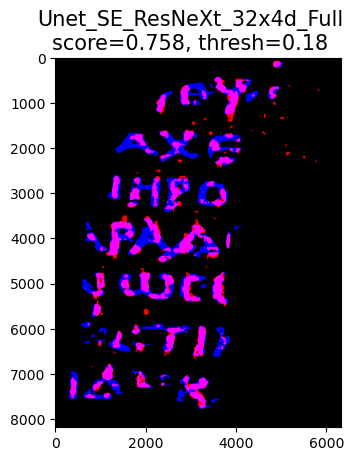

In [22]:
model = get_basic_model(("unet", "se_resnext50_32x4d"))
model_name = "Unet_SE_ResNeXt_32x4d_Full"
generate_results(model, model_name)

<font size="4" id="refs"><b>References</b></font>

["2.5d segmentaion baseline [training]" - Notebook by *tk*](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-training/notebook)

["2.5d segmentaion model with rotate TTA" - Notebook by *tk* and *yoyobar*](https://www.kaggle.com/code/yoyobar/2-5d-segmentaion-model-with-rotate-tta/notebook#summary)

["lb0.68 one-fold, stacked Unet" - Notebook by *hengck23*](https://www.kaggle.com/code/hengck23/lb0-68-one-fold-stacked-unet)